# Importing

Importing the necessary libraries

In [238]:
# libraries for data manipulation and cleaning
import numpy as np
import pandas as pd
import chardet

# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for machine learning
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# libraries used for better formatting
from IPython.display import Markdown, display


Importing the files

These files are gathered from the link: http://ergast.com/mrd/

This is a link to an API with a database that stores historical racing data. For this project, I used data downloaded on 4/5. By the time the project is submitted, there may be new race data added to the site as more races may happen between the download date and the due submission date for the project. 

In [239]:
folder = "/Users/natequan/Desktop/Spring2023/STAT4185/FinalProject/form1data/"

with open(f"{folder}/circuits.csv", 'rb') as f:
    result = chardet.detect(f.read())

files = [
    'circuits.csv',
    'constructor_results.csv',
    'constructors.csv', 
    'constructor_standings.csv',
    'drivers.csv',
    'driver_standings.csv',
    'lap_times.csv',
    'pit_stops.csv',
    'qualifying.csv',
    'races.csv',
    'results.csv',
    'status.csv'
    ]

df_dict = {}

for file in files:
    path = f"{folder}{file}"
    split_file = file.split(".")
    df_name = split_file[0]
    df_dict[df_name] = pd.read_csv(path, encoding = result['encoding'])

for key in df_dict.keys():
    print(f"{key} = {df_dict[key].shape}")

circuits = (77, 9)
constructor_results = (12200, 5)
constructors = (211, 5)
constructor_standings = (12961, 7)
drivers = (857, 9)
driver_standings = (33942, 7)
lap_times = (541113, 6)
pit_stops = (9773, 7)
qualifying = (9635, 9)
races = (1102, 18)
results = (25900, 18)
status = (139, 2)


# Cleaning and Manipulating the Data

Shows info on all 13 datasets

In [240]:
#for key in df_dict.keys():
#    display(Markdown(f'**<u>{key}</u>**'))
#    print(df_dict[key].info())

Null values in this dataset are listed as '\N', so we need to replace this with NaN values

In [241]:
for key in df_dict.keys():
    df_dict[key] = df_dict[key].replace('\\N', np.nan)

In [242]:
df_dict['results']['positionOrder'].astype('float64')

0         1.0
1         2.0
2         3.0
3         4.0
4         5.0
         ... 
25895    16.0
25896    17.0
25897    18.0
25898    19.0
25899    20.0
Name: positionOrder, Length: 25900, dtype: float64

Converting the "milliseconds" field in the lap_times df into seconds, in order to get the lap time in a numerical field.

In [243]:
df_dict['lap_times']['milliseconds'] = df_dict['lap_times']['milliseconds']/1000
df_dict['lap_times'].rename(columns = {'milliseconds': 'lap_time(seconds)'}, inplace = True)

Getting the slowest, average, and fastest lap time per racer per each race.

In [244]:
lap_vals = df_dict['lap_times'].groupby(['raceId', 'driverId']).agg({'lap_time(seconds)':['min', 'max', 'mean']}).reset_index()
lap_vals.columns = lap_vals.columns.map('_'.join)

lap_vals.rename(columns = {'raceId_': 'raceId', 'driverId_':'driverId', 'lap_time(seconds)_min':'fastest_lap',
                            'lap_time(seconds)_max':'slowest_lap', 'lap_time(seconds)_mean':'average_lap'}, inplace = True)

lap_vals.head()

,raceId,driverId,fastest_lap,slowest_lap,average_lap
0,1,1,89.020,153.309,97.563759
1,1,2,88.283,157.754,97.635672
2,1,3,87.706,155.699,97.612172
3,1,4,88.712,153.045,97.597638
4,1,6,89.923,104.899,91.822235


Cleaning the qualifying table: converting the q1, q2, and q3 times into a numerical seconds field.

In [245]:
def time_to_sec(time_str):
    time_str = str(time_str)
    time_list = time_str.split(':')
    if len(time_list) != 2:
        return np.nan
    else:
        min = time_list[0]
        sec = time_list[1]
    total_sec = int(min) *60 + float(sec)
    return total_sec
    

In [246]:
df_dict['qualifying']['q1'] = df_dict['qualifying']['q1'].apply(time_to_sec)
df_dict['qualifying']['q2'] = df_dict['qualifying']['q2'].apply(time_to_sec)
df_dict['qualifying']['q3'] = df_dict['qualifying']['q3'].apply(time_to_sec)


Converting the milliseconds field of the pitstops table to seconds to make it more usable

In [247]:
df_dict['pit_stops']['milliseconds'] = df_dict['pit_stops']['milliseconds'] / 1000
df_dict['pit_stops'].rename(columns = {'milliseconds':'pit_stop_seconds'}, inplace = True)


Creating a new pitstop df that counts the amount of pitstops per race, and total pitstop time in a race

In [248]:
ps = df_dict['pit_stops'].groupby(['raceId', 'driverId']).agg({'stop':'max', 'pit_stop_seconds':'sum'}).reset_index()

ps.rename(columns = {'stop':'#_of_pit_stops','pit_stop_seconds':'total_time_in_pit'}, inplace = True)

ps.head()

,raceId,driverId,#_of_pit_stops,total_time_in_pit
0,841,1,2,46.426
1,841,2,2,48.092
2,841,3,1,23.716
3,841,4,3,72.165
4,841,5,1,24.865


Cleaning the results table. Converting milliseconds to seconds again, converting fastestLapSpeed to float

In [249]:
df_dict['results']['milliseconds']= pd.to_numeric(df_dict['results']['milliseconds'])
df_dict['results']['milliseconds'] = df_dict['results']['milliseconds'] / 1000
df_dict['results'].rename(columns = {'milliseconds':'whole_race_time(sec)'}, inplace = True)

df_dict['results']['fastestLapSpeed'] = pd.to_numeric(df_dict['results']['fastestLapSpeed'])
df_dict['results']['rank'] = pd.to_numeric(df_dict['results']['rank'])
df_dict['results']['position'] = pd.to_numeric(df_dict['results']['position'])


df_dict['results'].rename(columns = {'positionOrder': 'final_race_position', 'fastestLap':'fastest_lap#', 'fastestLapSpeed': 'fastest_lap_speed(km/h)',
                                     'rank':'fastest_lap_rank'}, inplace = True)

df_dict['results'].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25900 entries, 0 to 25899
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   resultId                 25900 non-null  int64  
 1   raceId                   25900 non-null  int64  
 2   driverId                 25900 non-null  int64  
 3   constructorId            25900 non-null  int64  
 4   number                   25894 non-null  object 
 5   grid                     25900 non-null  int64  
 6   position                 15041 non-null  float64
 7   positionText             25900 non-null  object 
 8   final_race_position      25900 non-null  int64  
 9   points                   25900 non-null  float64
 10  laps                     25900 non-null  int64  
 11  time                     7128 non-null   object 
 12  whole_race_time(sec)     7127 non-null   float64
 13  fastest_lap#             7438 non-null   object 
 14  fastest_lap_rank      

Creates a dataframe that will be used to store driver data and results. Merges the drivers and drvier_standings tables to get the standings of the drivers after each race. It also gives details about accumulated placement points and how mnay wins so far throughout the season. 

In [250]:
dr = pd.merge(df_dict['drivers'], df_dict['driver_standings'], on = 'driverId')
dr.drop(columns = ['forename', 'surname', 'number', 'code', 'dob', 'nationality', 'url', 'driverStandingsId', 'positionText'], inplace = True)
dr.rename(columns = {'points': 'season_points', 'position': 'season_position', 'wins': 'season_wins'}, inplace = True)
dr.head(25)

,driverId,driverRef,raceId,season_points,season_position,season_wins
0,1,hamilton,18,10.0,1,1
1,1,hamilton,19,14.0,1,1
2,1,hamilton,20,14.0,3,1
3,1,hamilton,21,20.0,2,1
4,1,hamilton,22,28.0,3,1
5,1,hamilton,23,38.0,1,2
6,1,hamilton,24,38.0,2,2
7,1,hamilton,25,38.0,4,2
8,1,hamilton,26,48.0,1,3
9,1,hamilton,27,58.0,1,4


Merges the main, dr dataframe with the races dataframe in order to add more information about the races, such as time and year

In [251]:
dr = pd.merge(dr, df_dict['races'], on = 'raceId')
dr.head()

,driverId,driverRef,raceId,season_points,season_position,season_wins,year,round,circuitId,name,...,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,hamilton,18,10.0,1,1,2008,1,1,Australian Grand Prix,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,heidfeld,18,8.0,2,0,2008,1,1,Australian Grand Prix,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,rosberg,18,6.0,3,0,2008,1,1,Australian Grand Prix,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,alonso,18,5.0,4,0,2008,1,1,Australian Grand Prix,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,kovalainen,18,4.0,5,0,2008,1,1,Australian Grand Prix,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Converting the date and time fields into numerical fields.

In [252]:
dr.drop(columns = ['year', 'round', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], inplace = True)

#dr['date'] = pd.to_datetime(dr['date'])
#dr['race_year'] = dr['date'].dt.year
#dr['race_month'] = dr['date'].dt.month
#dr['race_day'] = dr['date'].dt.day

#dr['time'] = pd.to_datetime(dr['time'])
#dr['race_hour'] = dr['time'].dt.hour
#dr['race_min'] = dr['time'].dt.minute

dr.drop(columns = ['date', 'time'], inplace = True)
dr.rename(columns = {'name': 'race_name'}, inplace = True)

dr.head()

,driverId,driverRef,raceId,season_points,season_position,season_wins,circuitId,race_name
0,1,hamilton,18,10.0,1,1,1,Australian Grand Prix
1,2,heidfeld,18,8.0,2,0,1,Australian Grand Prix
2,3,rosberg,18,6.0,3,0,1,Australian Grand Prix
3,4,alonso,18,5.0,4,0,1,Australian Grand Prix
4,5,kovalainen,18,4.0,5,0,1,Australian Grand Prix


Merging the main, dr dataframe with the lap_vals dataframe in order to add lap time data for each race.

In [253]:
dr = pd.merge(dr, lap_vals, on = ['driverId', 'raceId'])
dr.head()

,driverId,driverRef,raceId,season_points,season_position,season_wins,circuitId,race_name,fastest_lap,slowest_lap,average_lap
0,1,hamilton,18,10.0,1,1,1,Australian Grand Prix,87.452,166.432,98.114069
1,2,heidfeld,18,8.0,2,0,1,Australian Grand Prix,87.739,166.678,98.208517
2,3,rosberg,18,6.0,3,0,1,Australian Grand Prix,88.090,156.683,98.254810
3,4,alonso,18,5.0,4,0,1,Australian Grand Prix,88.603,170.306,98.410293
4,5,kovalainen,18,4.0,5,0,1,Australian Grand Prix,87.418,175.160,98.424655


Merging the dr dataframe with the qualifying dataframe in order to add each driver's qualifying data for each race.

In [254]:
dr = pd.merge(dr, df_dict['qualifying'], on = ['raceId', 'driverId'])
dr.head()

,driverId,driverRef,raceId,season_points,season_position,season_wins,circuitId,race_name,fastest_lap,slowest_lap,average_lap,qualifyId,constructorId,number,position,q1,q2,q3
0,1,hamilton,18,10.0,1,1,1,Australian Grand Prix,87.452,166.432,98.114069,1,1,22,1,86.572,85.187,86.714
1,2,heidfeld,18,8.0,2,0,1,Australian Grand Prix,87.739,166.678,98.208517,5,2,3,5,85.960,85.518,87.236
2,3,rosberg,18,6.0,3,0,1,Australian Grand Prix,88.090,156.683,98.254810,7,3,7,7,86.295,86.059,88.687
3,4,alonso,18,5.0,4,0,1,Australian Grand Prix,88.603,170.306,98.410293,12,4,5,12,86.907,86.188,NaN
4,5,kovalainen,18,4.0,5,0,1,Australian Grand Prix,87.418,175.160,98.424655,3,1,23,3,85.664,85.452,87.079


Editing the new dataframe by dropping unnecessary columns and renaming certain columns to make them more comprehensible. 

In [255]:
dr.drop(columns = ['qualifyId', 'number'], inplace = True)
dr.rename(columns = {'position': 'qual_position', 'q1': 'q1_time', 'q2': 'q2_time', 'q3': 'q3_time'}, inplace = True)
dr.columns

Index(['driverId', 'driverRef', 'raceId', 'season_points', 'season_position',
       'season_wins', 'circuitId', 'race_name', 'fastest_lap', 'slowest_lap',
       'average_lap', 'constructorId', 'qual_position', 'q1_time', 'q2_time',
       'q3_time'],
      dtype='object')

Merging the dr dataframe with the constructors dataframe in order to get the "team" that each drvier is associated with. From here, I once again dropped unnecessary columns and renamed a column to make it more clear. 

In [256]:
dr = pd.merge(dr, df_dict['constructors'], on = 'constructorId')
dr.drop(columns = ['url', 'nationality', 'constructorRef'], inplace = True)
dr.rename(columns = {'name':'constructor_name'}, inplace = True)
dr.head()

,driverId,driverRef,raceId,season_points,season_position,season_wins,circuitId,race_name,fastest_lap,slowest_lap,average_lap,constructorId,qual_position,q1_time,q2_time,q3_time,constructor_name
0,1,hamilton,18,10.0,1,1,1,Australian Grand Prix,87.452,166.432,98.114069,1,1,86.572,85.187,86.714,McLaren
1,5,kovalainen,18,4.0,5,0,1,Australian Grand Prix,87.418,175.160,98.424655,1,3,85.664,85.452,87.079,McLaren
2,1,hamilton,19,14.0,1,1,2,Malaysian Grand Prix,95.462,135.491,98.662554,1,4,95.392,94.627,96.709,McLaren
3,5,kovalainen,19,10.0,4,0,2,Malaysian Grand Prix,95.922,125.997,98.517946,1,3,95.227,94.759,96.613,McLaren
4,1,hamilton,20,14.0,3,1,3,Bahrain Grand Prix,95.520,129.676,97.906857,1,3,92.750,91.922,93.292,McLaren


Merging the dr dataframe with a ps dataframe, which was created earlier and contains some pit stop data, such as the number of stops and the amount of time spent in the pit stop per each race for a driver. 

In [257]:
dr = pd.merge(dr, ps, on = ['driverId', 'raceId'])
dr.head()

,driverId,driverRef,raceId,season_points,season_position,season_wins,circuitId,race_name,fastest_lap,slowest_lap,average_lap,constructorId,qual_position,q1_time,q2_time,q3_time,constructor_name,#_of_pit_stops,total_time_in_pit
0,4,alonso,969,0.0,14,0,1,Australian Grand Prix,90.077,109.469,91.728380,1,13,85.872,85.425,NaN,McLaren,1,22.484
1,838,vandoorne,969,0.0,13,0,1,Australian Grand Prix,89.440,128.894,92.705582,1,18,86.858,NaN,NaN,McLaren,1,39.562
2,1,hamilton,842,22.0,3,0,2,Malaysian Grand Prix,101.512,124.636,105.531946,1,2,96.861,95.852,94.974,McLaren,4,93.011
3,18,button,842,26.0,2,0,2,Malaysian Grand Prix,101.264,123.347,104.698089,1,4,97.033,95.569,95.200,McLaren,3,67.354
4,1,hamilton,841,18.0,2,0,1,Australian Grand Prix,90.314,113.298,92.975103,1,2,85.384,84.595,84.307,McLaren,2,46.426


Merging the dr dataframe and the results dataframe to get necessary data about the final results of the race for each driver. Also dropped unnecessary columns once again. 

In [258]:
dr = pd.merge(dr, df_dict['results'], on = ['driverId', 'raceId'])
dr.drop(columns = ['constructorId_y', 'number', 'grid', 'positionText', 'position', 'points',
                   'laps', 'time', 'fastestLapTime'], inplace = True)
dr.columns

Index(['driverId', 'driverRef', 'raceId', 'season_points', 'season_position',
       'season_wins', 'circuitId', 'race_name', 'fastest_lap', 'slowest_lap',
       'average_lap', 'constructorId_x', 'qual_position', 'q1_time', 'q2_time',
       'q3_time', 'constructor_name', '#_of_pit_stops', 'total_time_in_pit',
       'resultId', 'final_race_position', 'whole_race_time(sec)',
       'fastest_lap#', 'fastest_lap_rank', 'fastest_lap_speed(km/h)',
       'statusId'],
      dtype='object')

Renaming a column and converting an object column into a numeric column

In [259]:
dr.rename(columns = {'constructorId_x': 'constructorId'}, inplace = True)
dr['fastest_lap#'] = pd.to_numeric(dr['fastest_lap#'])

Since I am going to use a decision tree, I need to get rid of all object columns: 
* Drivers will be identified based on their ID
* Race Name will be identified based on the circuit_id
* Constructors will be identified based on their ID
    

In [260]:
dr.drop(columns = ['resultId', 'driverRef', 'race_name', 'constructor_name'], inplace = True)

The sci-kit learn decision tree model I want to use does not support NaN values, so I will have to impute values for the following columns:
* q1_time
* q2_time
* q3_time
* whole_race_time(sec)
* fastest_lap#
* fastest_lap_speed(km/h)


To impute q1_time, I will group the race by race_id and assign each driver the maximum q1_time in that session. I'm assuming that if drivers do not have a q1_time, they did not put up a valid lap for q1, so they deserve to have the worst time. We will also penalize them by adding 1 second to the maximum time.

This will also go for q2 and q3. For these, there are more NaN values because drivers must be in the top part of their previous section to qualify for q2 and q3. As a result, we will also fill in their times with the maximum time for each of these sessions plus a 1 second penalty for either not making it, or not putting up a lap.

In [261]:
def impute_max(temp, actual, col):
    for race_id, times in temp:
        max_time = times[col].max()
        actual[col] = actual[col].fillna(max_time + 1)

race_id_group = dr.groupby('raceId')

impute_max(race_id_group, dr, 'q1_time')
impute_max(race_id_group, dr, 'q2_time')
impute_max(race_id_group, dr, 'q3_time')



To account for the missing values in the whole_race_time(sec) column, I will drop the column due to the fact there are too many missing values. In the case of this columns, almost 50% of the values are missing, which could be due to a multitude of drivers being unable to finish races. Imputing this data would have a negative effect on this variable since I will be generating almost half of the data, which would not give good results

In [262]:
dr.drop(columns = 'whole_race_time(sec)', inplace = True)

fastest_lap# will actually be dropped because it is not a necessary variable.

In [263]:
dr.drop(columns = 'fastest_lap#', inplace = True)

fastest_lap_speed will be imputed in a similar way as q1, q2, and q3 times. However, rather than the maximum value for lap speed, we will just take average of the fastest lap speeds for a given race.

In [264]:
lap_speed = dr.groupby('raceId')

for race_id, speed in lap_speed:
    avg_speed = speed['fastest_lap_speed(km/h)'].mean()
    dr['fastest_lap_speed(km/h)'] = dr['fastest_lap_speed(km/h)'].fillna(avg_speed)

Dropping the raceId column since it is no longer needed

In [280]:
dr.drop(columns = 'raceId', inplace = True)

In [281]:
dr.columns

Index(['driverId', 'season_points', 'season_position', 'season_wins',
       'circuitId', 'fastest_lap', 'slowest_lap', 'average_lap',
       'constructorId', 'qual_position', 'q1_time', 'q2_time', 'q3_time',
       '#_of_pit_stops', 'total_time_in_pit', 'final_race_position',
       'fastest_lap_rank', 'fastest_lap_speed(km/h)', 'statusId'],
      dtype='object')

# Implementing a Machine Learning Model

For this part of the project, I will be using a decision tree in order to identify important features of the most successful drivers. The idea of "successful drivers" will be based on their final race positions. 

This sets X to all columns besides the final race position because we are trying to identify the features in X that lead to being successful.

In [282]:
X = dr.drop(columns = 'final_race_position')

This sets y equal to final_race_position because that is the metric that we are using to determine how "successful" drivers are.

In [283]:
y = dr['final_race_position']

Splitting the data into test and training data sets

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.3, random_state = 42)


Make the decision tree model

In [285]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

Score the decision tree model

In [286]:
accuracy = tree.score(X_test, y_test)
accuracy

0.17874736101337085

Sorting and printing out the features and their importance

In [287]:
importances = tree.feature_importances_

feature_list = []

for ind, feature in enumerate(X.columns):
    feature_list.append(feature)

sorted_index = importances.argsort()

sorted_importances = []
sorted_features = []

for i in sorted_index:
    sorted_importances.append(importances[i])
    sorted_features.append(feature_list[i])

for i in range(len(sorted_features)):
    print(f'{sorted_features[i]} importance: {sorted_importances[i]}')

season_wins importance: 0.010562954804397838
#_of_pit_stops importance: 0.02169764503128823
q3_time importance: 0.021744653906399583
q2_time importance: 0.03279603998946926
statusId importance: 0.03918264848279978
fastest_lap importance: 0.049935209454972165
circuitId importance: 0.052532119226573394
q1_time importance: 0.052616398791762616
average_lap importance: 0.053354872363701546
constructorId importance: 0.05346822145056135
driverId importance: 0.05842363703089448
fastest_lap_speed(km/h) importance: 0.0674188268996097
fastest_lap_rank importance: 0.07112396889312465
qual_position importance: 0.0715578533898016
season_points importance: 0.07608327112244516
slowest_lap importance: 0.07910132189397355
total_time_in_pit importance: 0.08737833154055703
season_position importance: 0.10102202572766807


Plotting the features and their importances

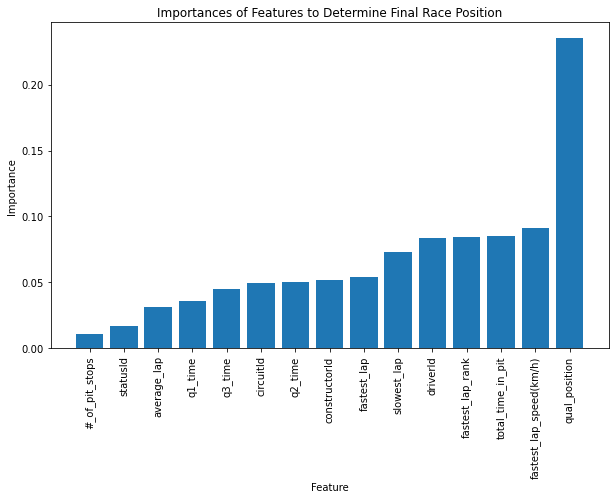

In [296]:
plt.figure(figsize = (10, 6))
plt.bar(sorted_features, sorted_importances)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Importances of Features to Determine Final Race Position")
plt.xticks(rotation = 90)
plt.show()